In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Cleaning**

In [217]:
df = pd.read_csv('synthetic_data.csv')

# Check for missing values
df.isnull().sum()

x         0
y         0
z         0
status    0
dtype: int64

In [218]:
# Remove duplicates
df.drop_duplicates()

,x,y,z,status
0,-0.152375,-0.898320,-0.371662,idle
1,-0.133481,-0.877780,-0.385113,idle
2,-0.121285,-0.909976,-0.381254,idle
3,-0.127859,-0.899945,-0.426131,idle
4,-0.131367,-0.919183,-0.425946,idle
...,...,...,...,...
99995,0.683156,0.519731,-0.366067,soft_concrete
99996,0.787088,0.319512,-0.601208,soft_concrete
99997,0.742647,0.382496,-0.581437,soft_concrete
99998,0.627654,0.409057,-0.536827,soft_concrete


In [165]:
# Get the indices of the first 10 rows and last 10 rows
indices_to_drop = list(range(1000)) + list(range(len(df) - 1200, len(df)))

# Drop those indices
df = df.drop(indices_to_drop)



In [219]:
idle_data = df[df['status'] == 'idle']
soft_concrete_data = df[df['status'] == 'soft_concrete']
hard_concrete_data = df[df['status'] == 'hard_concrete']
minor_vibration_data = df[df['status'] == 'minor_vibration']

def remove_outliers_by_iqr(data, columns):
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[~((data[columns] < lower_bound) | (data[columns] > upper_bound)).any(axis=1)]

# Apply IQR method to each scenario
idle_data_cleaned = remove_outliers_by_iqr(idle_data, ['x', 'y', 'z'])
soft_concrete_data_cleaned = remove_outliers_by_iqr(soft_concrete_data, ['x', 'y', 'z'])
hard_concrete_data_cleaned = remove_outliers_by_iqr(hard_concrete_data, ['x', 'y', 'z'])
minor_vibration_data_cleaned = remove_outliers_by_iqr(minor_vibration_data, ['x', 'y', 'z'])


In [206]:
from scipy.stats import zscore

idle_data = df[df['status'] == 'idle']
soft_concrete_data = df[df['status'] == 'soft_concrete']
hard_concrete_data = df[df['status'] == 'hard_concrete']
minor_vibration_data = df[df['status'] == 'minor_vibration']

def remove_outliers_by_zscore(data, columns, threshold=1):
    z_scores = zscore(data[columns])
    return data[(z_scores < threshold).all(axis=1)]

# Remove outliers for each scenario based on 'x', 'y', 'z'
idle_data_cleaned = remove_outliers_by_zscore(idle_data, ['x', 'y', 'z'])
soft_concrete_data_cleaned = remove_outliers_by_zscore(soft_concrete_data, ['x', 'y', 'z'])
hard_concrete_data_cleaned = remove_outliers_by_zscore(hard_concrete_data, ['x', 'y', 'z'])
minor_vibration_data_cleaned = remove_outliers_by_zscore(minor_vibration_data, ['x', 'y', 'z'])

print(f"Idle Data After Removing Outliers: {len(idle_data_cleaned)} rows")
print(f"Soft Concrete Data After Removing Outliers: {len(soft_concrete_data_cleaned)} rows")
print(f"Hard Concrete Data After Removing Outliers: {len(hard_concrete_data_cleaned)} rows")
print(f"Minor Vibration Data After Removing Outliers: {len(minor_vibration_data_cleaned)} rows")

Idle Data After Removing Outliers: 14867 rows
Soft Concrete Data After Removing Outliers: 14799 rows
Hard Concrete Data After Removing Outliers: 14855 rows
Minor Vibration Data After Removing Outliers: 14829 rows


In [ ]:
from scipy.stats import zscore

z_scores = zscore(df[['x', 'y', 'z']])
df = df[(z_scores < 3).all(axis=1)]  # Keep rows within 3 standard deviations

**Normalization of Data**

In [220]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

In [221]:
df.head()

,x,y,z,status
0,-1.027891,-0.970761,-0.582901,idle
1,-0.989418,-0.938024,-0.619480,idle
2,-0.964582,-0.989339,-0.608987,idle
3,-0.977969,-0.973351,-0.731030,idle
4,-0.985113,-1.004014,-0.730528,idle


**Feature Engineering**

In [222]:
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)


In [223]:
window_size = 10

# Calculate rolling mean, standard deviation, max, and min
df['rolling_mean'] = df['magnitude'].rolling(window=window_size).mean()
df['rolling_std'] = df['magnitude'].rolling(window=window_size).std()
df['rolling_max'] = df['magnitude'].rolling(window=window_size).max()
df['rolling_min'] = df['magnitude'].rolling(window=window_size).min()


In [224]:
from scipy.fft import fft

# Compute FFT to analyze frequency
df['fft'] = fft(df['magnitude'])
df['fft_amplitude'] = np.abs(df['fft'][:len(df)])


In [161]:
from scipy.stats import zscore

# Function to calculate z-scores and filter out outliers
def remove_outliers(data, column_name):
    data['z_score'] = zscore(data[column_name])
    filtered_data = data[(data['z_score'] <= 3) & (data['z_score'] >= -3)]
    return filtered_data.drop(columns=['z_score'])  # Remove z_score column after filtering

# Remove outliers for each scenario
idle_cleaned = remove_outliers(idle_data.copy(), 'fft_amplitude')
soft_concrete_cleaned = remove_outliers(soft_concrete_data.copy(), 'fft_amplitude')
hard_concrete_cleaned = remove_outliers(hard_concrete_data.copy(), 'fft_amplitude')
minor_vibration_cleaned = remove_outliers(minor_vibration_data.copy(), 'fft_amplitude')

In [212]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['status_encoded'] = encoder.fit_transform(df['status'])


In [144]:
df.to_csv("test3.csv", index=False)

**Train Test Split**

In [213]:
from sklearn.model_selection import train_test_split

X = df[['magnitude', 'rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min']]
y = df['status_encoded']

# Handle NaN values generated by rolling operations
X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train Model**

In [214]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [215]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4963
           1       0.94      0.97      0.96      5029
           2       0.97      0.93      0.95      5133
           3       0.96      0.96      0.96      4874

    accuracy                           0.96     19999
   macro avg       0.96      0.96      0.96     19999
weighted avg       0.96      0.96      0.96     19999

Accuracy: 0.96


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.2f}")


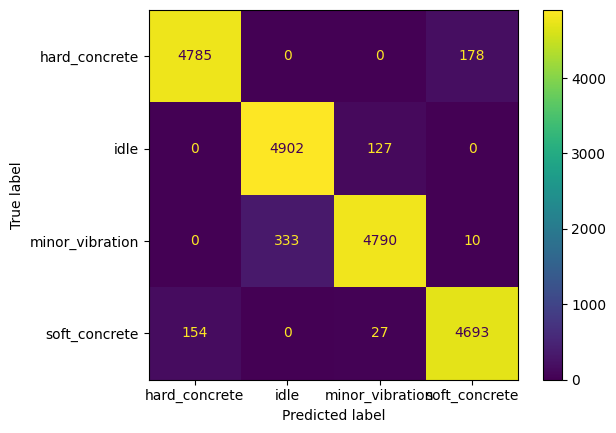

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot()


In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=encoder.classes_))


                 precision    recall  f1-score   support

  hard_concrete       0.97      0.96      0.97      4963
           idle       0.94      0.97      0.96      5029
minor_vibration       0.97      0.93      0.95      5133
  soft_concrete       0.96      0.96      0.96      4874

       accuracy                           0.96     19999
      macro avg       0.96      0.96      0.96     19999
   weighted avg       0.96      0.96      0.96     19999



In [ ]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_acc = baseline.score(X_test, y_test)
print(f"Baseline Accuracy: {baseline_acc:.2f}")


Baseline Accuracy: 0.24


**Save Model**

In [13]:
import joblib

# Save the model to a file
joblib.dump(clf, "predictive_maintenance_model.pkl")

['predictive_maintenance_model.pkl']

In [17]:
df.head()

,x,y,z,status,magnitude,rolling_mean,rolling_std,rolling_max,rolling_min,fft,fft_amplitude,status_encoded
0,-1.027891,-0.970761,-0.582901,idle,1.529284,NaN,NaN,NaN,NaN,169747.678415- 0.000000j,169747.678415,1
1,-0.989418,-0.938024,-0.619480,idle,1.497528,NaN,NaN,NaN,NaN,-6390.727148+ 9529.477330j,11473.984994,1
2,-0.964582,-0.989339,-0.608987,idle,1.509992,NaN,NaN,NaN,NaN,99.553973- 7009.586826j,7010.293750,1
3,-0.977969,-0.973351,-0.731030,idle,1.561487,NaN,NaN,NaN,NaN,2141.946018+ 3256.994012j,3898.197370,1
4,-0.985113,-1.004014,-0.730528,idle,1.584980,NaN,NaN,NaN,NaN,24.485652+ 0.708724j,24.495907,1


In [18]:
df.to_csv("test.csv", index=False)

In [ ]:
# Group the data by 'status' and calculate the minimum and maximum fft_amplitude
min_max_fft_amplitude = df.groupby('status')['fft'].agg(['min', 'max']).reset_index()

# Display the results
print(min_max_fft_amplitude)


In [23]:
np.nan_to_num(df['fft_amplitude'])

array([169747.67841481,  11473.98499436,   7010.29375002, ...,
            0.        ,      0.        ,      0.        ])

In [145]:
df

,x,y,z,status,magnitude,rolling_mean,rolling_std,rolling_max,rolling_min,fft,fft_amplitude,status_encoded
1000,-0.977660,-0.940369,-0.529463,idle,1.456174,1.539308,0.062359,1.643024,1.456174,53.952567+ 20.945499j,57.875673,1
1001,-0.995381,-0.991547,-0.730852,idle,1.583696,1.547515,0.062249,1.643024,1.456174,21.308612+ 55.435093j,59.389448,1
1002,-0.988552,-0.947882,-0.607653,idle,1.498318,1.546047,0.063318,1.643024,1.456174,-72.141722+ 51.607419j,88.700360,1
1003,-0.984568,-0.935117,-0.703180,idle,1.529143,1.544272,0.063540,1.643024,1.456174,-36.112811- 56.888393j,67.382671,1
1004,-0.994255,-1.043372,-0.639558,idle,1.576770,1.549722,0.063780,1.643024,1.456174,-25.420972- 29.474043j,38.922294,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.674709,1.290142,-0.567021,soft_concrete,1.562438,1.647907,0.334415,2.254360,1.259821,-1242.599412-1915.586387j,2283.314368,3
99996,0.886353,0.971075,-1.209950,soft_concrete,1.786782,1.675638,0.333155,2.254360,1.259821,-36.694163+ 2.585283j,36.785124,3
99997,0.795855,1.071447,-1.155891,soft_concrete,1.765635,1.626765,0.268375,1.979044,1.259821,2185.981891-3322.004021j,3976.710644,3
99998,0.561686,1.113774,-1.033918,soft_concrete,1.620175,1.656280,0.246872,1.979044,1.259821,78.650984+7027.048329j,7027.488470,3


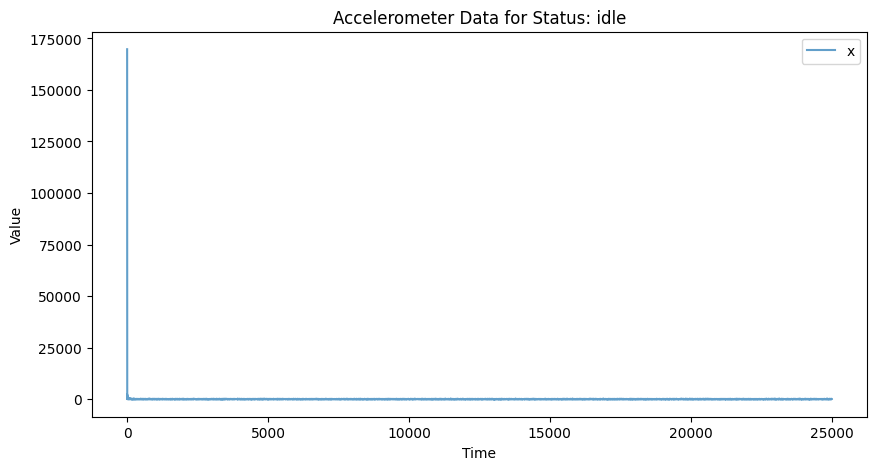

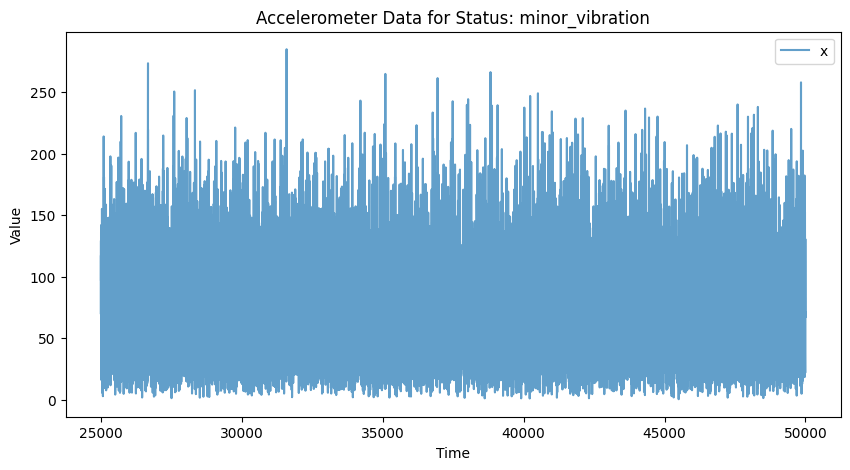

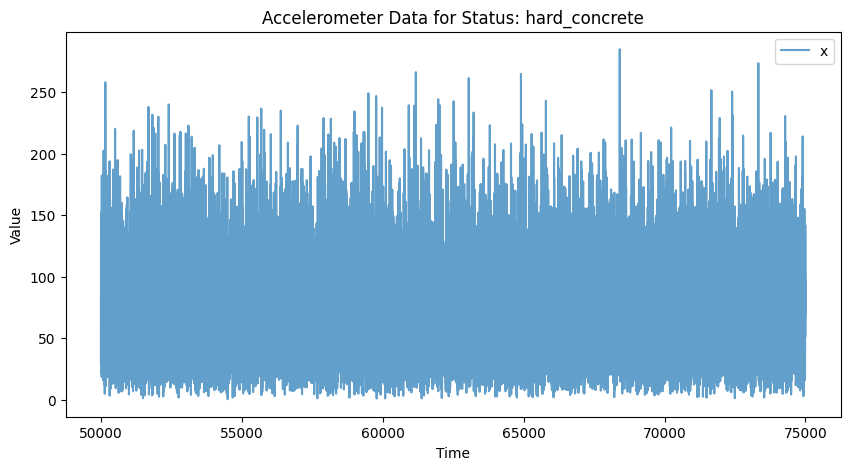

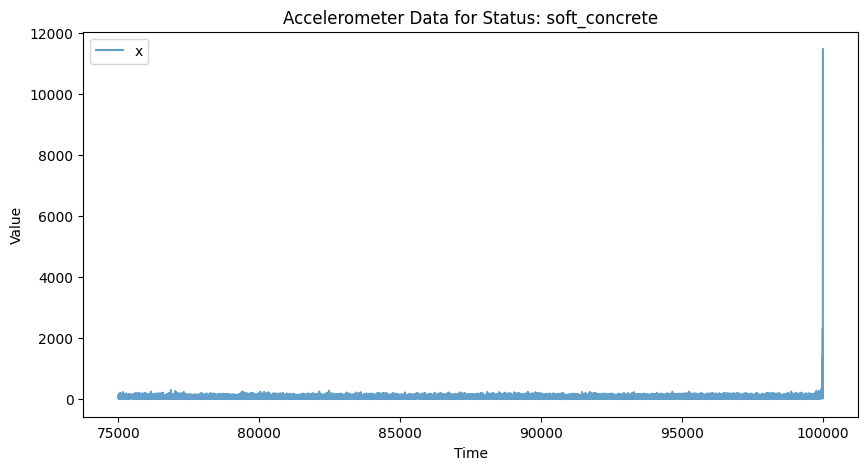

In [225]:
df['time'] = range(len(df))
statuses = df['status'].unique()

for status in statuses:
    subset = df[df['status'] == status]
    plt.figure(figsize=(10, 5))
    plt.plot(subset['time'], subset['fft_amplitude'], label='x', alpha=0.7)
    plt.title(f'Accelerometer Data for Status: {status}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [226]:
df.to_csv("test4.csv", index=False)